In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


/var/folders/xf/z4195tzn5tq20kbd1dlbsg3m0000gn/T/ipykernel_2277/2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  func(*a

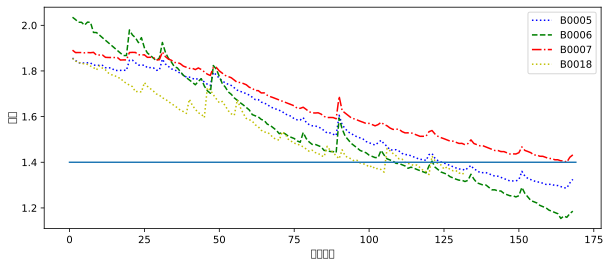

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [6]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 5, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y[:, -1].shape)
        
        print(x)
        print(y[:, -1])
        break



validate_train_iter(train_iter)

torch.Size([5, 16])
torch.Size([5])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
        [2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456, 1.9348,
         1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676, 1.8676],
        [2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456, 1.9348, 1.9233,
         1.9119, 1.9011, 1.8892, 1.8783, 1.8676, 1.8676, 1.9796]])
tensor([1.8783, 1.8676, 1.8676, 1.9796, 1.9575])


## 创建评估指标函数

In [7]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 绘制 out 和  tgt_y的对比图

In [8]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 搭建模型

In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [10]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 16, 1])


## 一个批次的训练函数

In [11]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [12]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, Rated_Capacity)
            test_y = test_data.copy()
            
            mae, rmse = evaluation(test_y, pre_list)
            re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            # print('out is ')
            # print(len(out))
            # print('tgt_y is ')
            # print(len(tgt_y))
            
            
            matlab_make(pre_list, test_y)
            
            #print('epoch:{:<4d} , loss:{:<6.10f} '.format(epoch, train_loss))
            
#             if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
#                 break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [14]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练

以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0061568939 , MAE:0.2510 , RMSE:0.3029 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

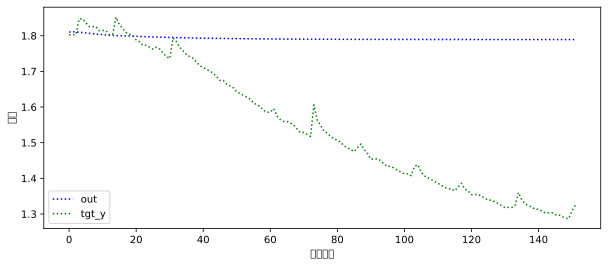

epoch:199  , loss:0.0026916838 , MAE:0.2648 , RMSE:0.3167 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

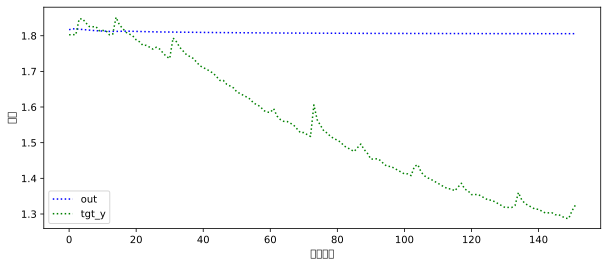

epoch:299  , loss:0.0016839259 , MAE:0.2792 , RMSE:0.3316 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

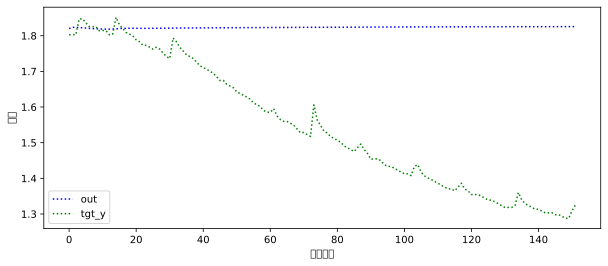

epoch:399  , loss:0.0012340365 , MAE:0.2337 , RMSE:0.2774 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

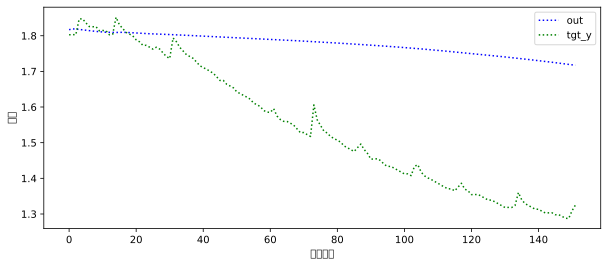

epoch:499  , loss:0.0012102934 , MAE:0.1806 , RMSE:0.2137 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

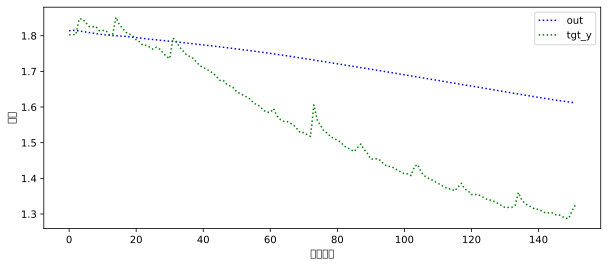

epoch:599  , loss:0.0009979833 , MAE:0.0947 , RMSE:0.1126 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

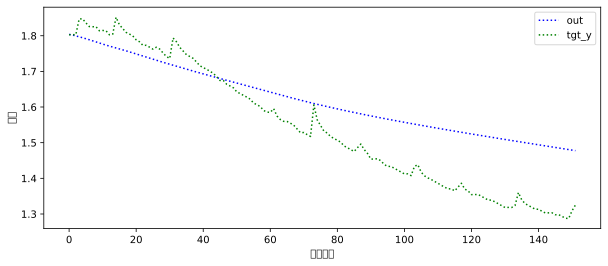

epoch:699  , loss:0.0007077865 , MAE:0.1256 , RMSE:0.1516 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

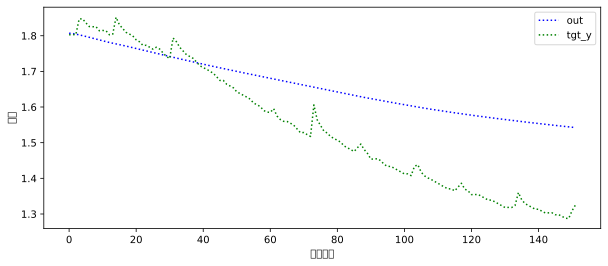

epoch:799  , loss:0.0005772415 , MAE:0.0543 , RMSE:0.0601 , RE:0.2569


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

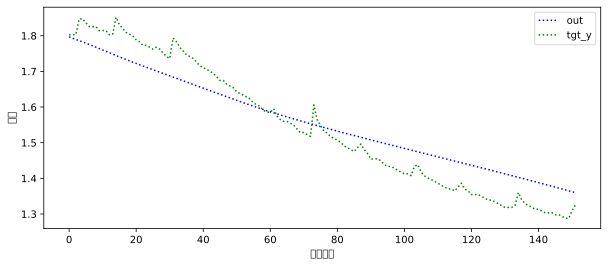

epoch:899  , loss:0.0005849469 , MAE:0.0469 , RMSE:0.0529 , RE:0.1743


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

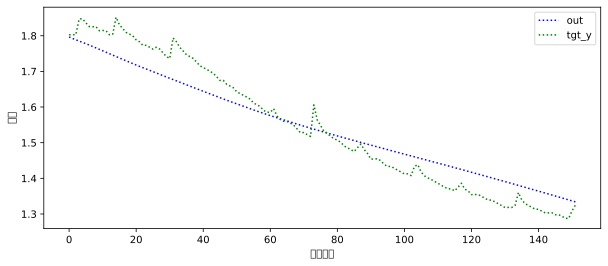

epoch:999  , loss:0.0007396365 , MAE:0.0677 , RMSE:0.0768 , RE:0.3945


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

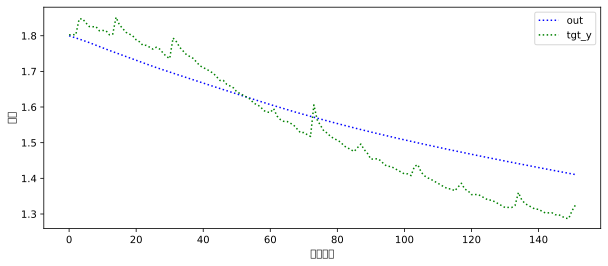

epoch:1099 , loss:0.0004880735 , MAE:0.0428 , RMSE:0.0517 , RE:0.0917


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

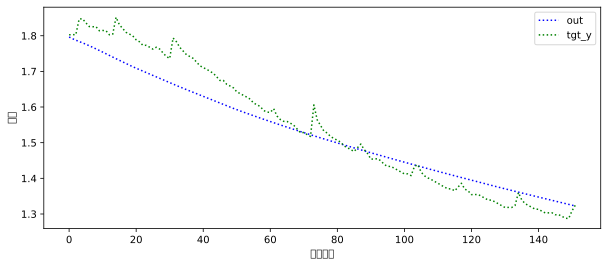

epoch:1199 , loss:0.0005289965 , MAE:0.0577 , RMSE:0.0643 , RE:0.2936


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

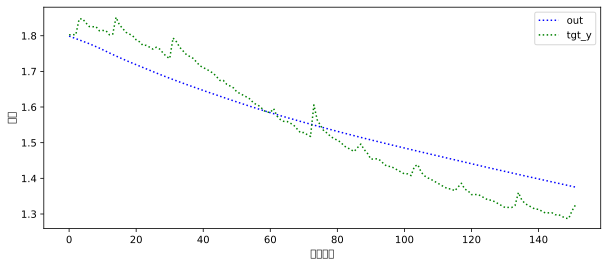

epoch:1299 , loss:0.0004659755 , MAE:0.0410 , RMSE:0.0525 , RE:0.0459


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

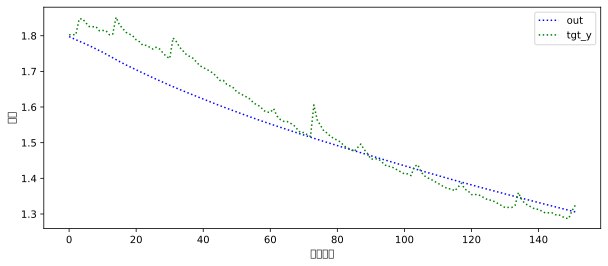

epoch:1399 , loss:0.0004163956 , MAE:0.0456 , RMSE:0.0572 , RE:0.0550


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

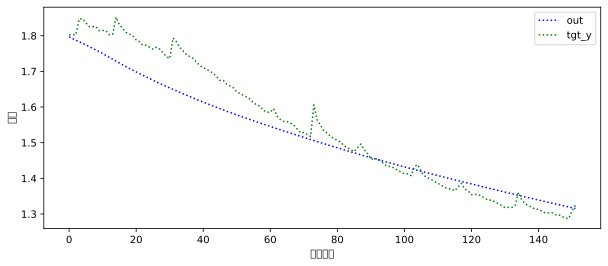

epoch:1499 , loss:0.0003265722 , MAE:0.0440 , RMSE:0.0551 , RE:0.0550


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

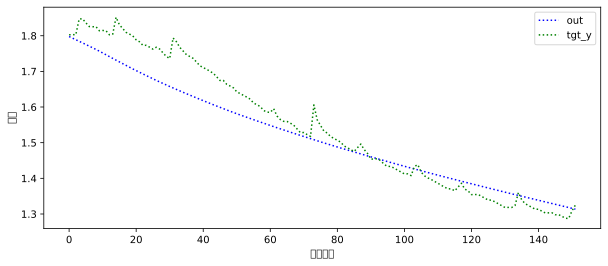

epoch:1599 , loss:0.0004445850 , MAE:0.0541 , RMSE:0.0609 , RE:0.2844


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

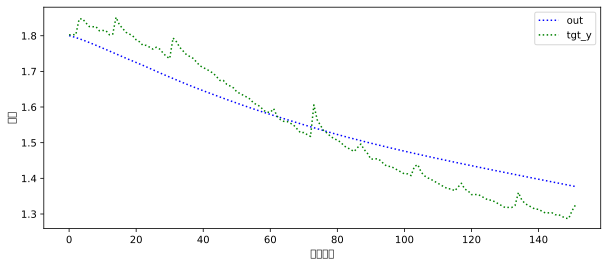

epoch:1699 , loss:0.0003758206 , MAE:0.0466 , RMSE:0.0610 , RE:0.0092


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

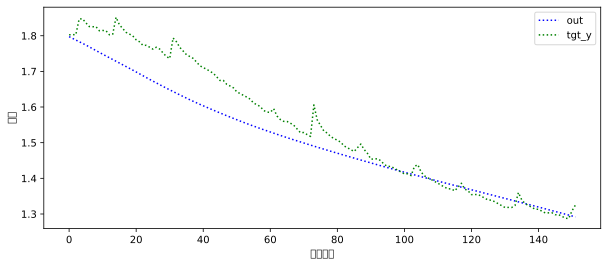

epoch:1799 , loss:0.0002232403 , MAE:0.0449 , RMSE:0.0546 , RE:0.0826


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

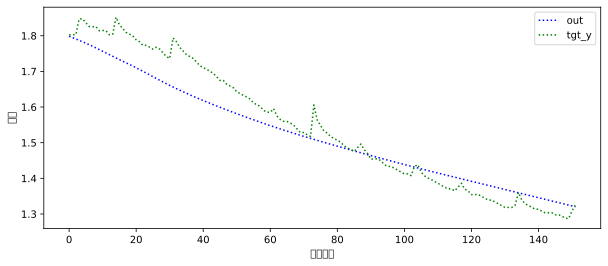

epoch:1899 , loss:0.0003567326 , MAE:0.0737 , RMSE:0.0808 , RE:0.1376


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

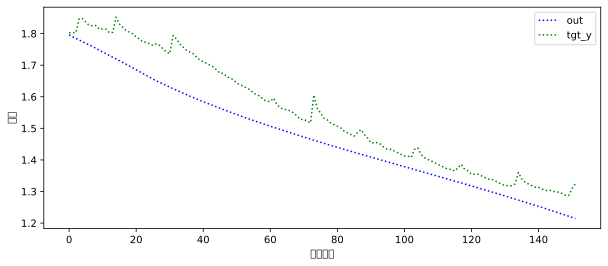

epoch:1999 , loss:0.0003835586 , MAE:0.0534 , RMSE:0.0610 , RE:0.1927


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

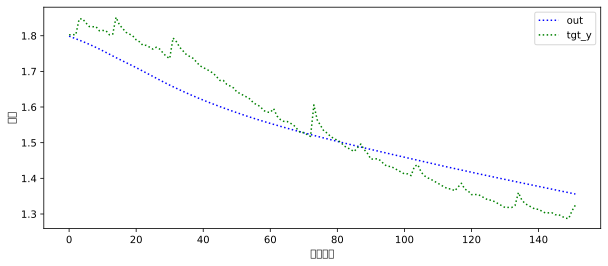

以电池 B0006 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0137414904 , MAE:0.2196 , RMSE:0.2558 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

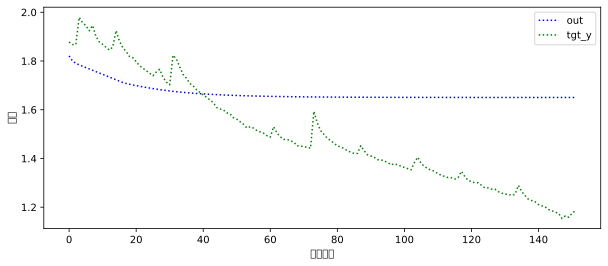

epoch:199  , loss:0.0044812560 , MAE:0.3289 , RMSE:0.3806 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

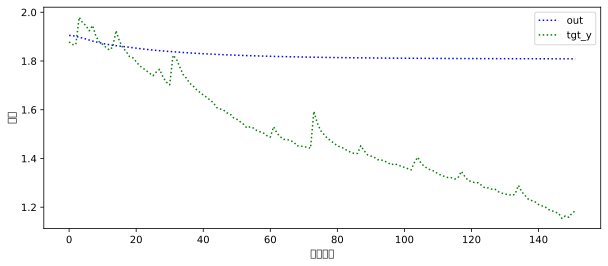

epoch:299  , loss:0.0026321241 , MAE:0.3504 , RMSE:0.4025 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

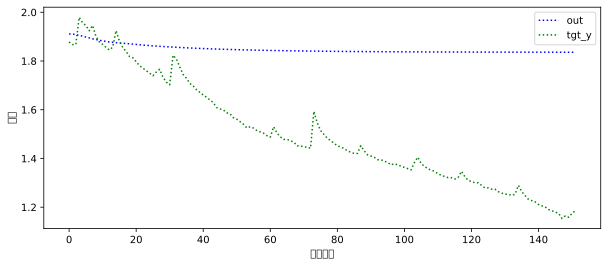

epoch:399  , loss:0.0018250004 , MAE:0.3321 , RMSE:0.3841 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

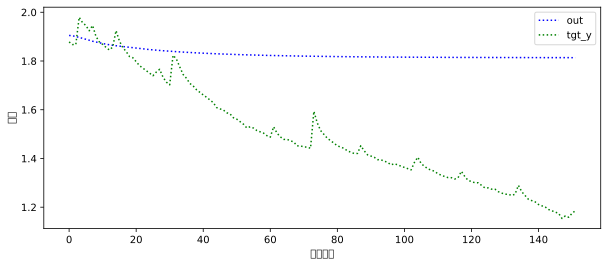

epoch:499  , loss:0.0013368087 , MAE:0.3337 , RMSE:0.3857 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

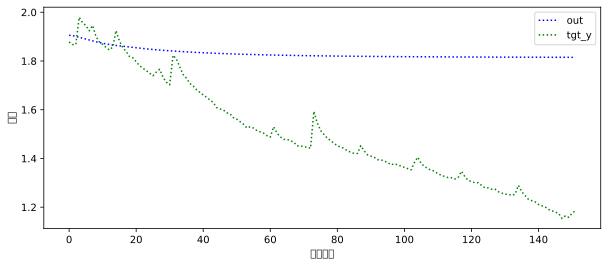

epoch:599  , loss:0.0014553607 , MAE:0.3582 , RMSE:0.4107 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

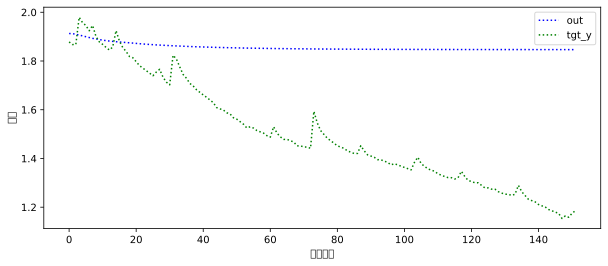

epoch:699  , loss:0.0013240025 , MAE:0.3600 , RMSE:0.4122 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

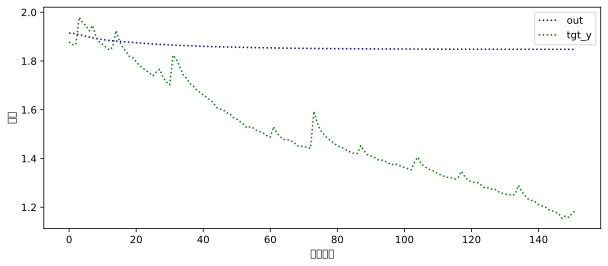

epoch:799  , loss:0.0008810060 , MAE:0.3629 , RMSE:0.4149 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

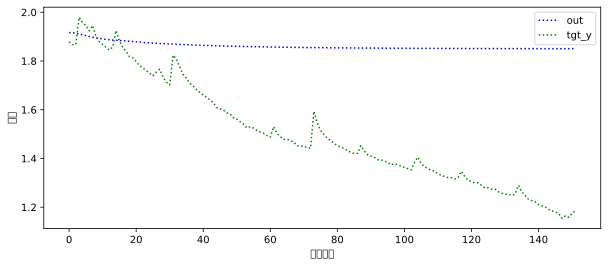

epoch:899  , loss:0.0007528854 , MAE:0.3761 , RMSE:0.4282 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

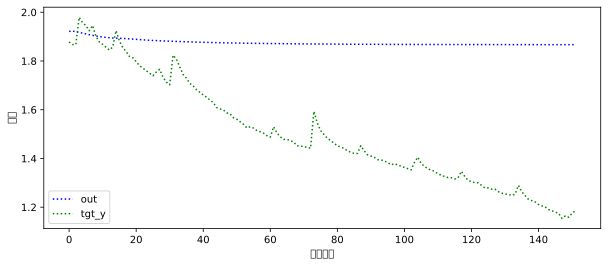

epoch:999  , loss:0.0006266265 , MAE:0.3052 , RMSE:0.3453 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

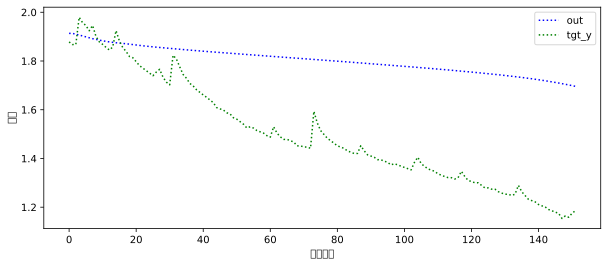

epoch:1099 , loss:0.0007089986 , MAE:0.3453 , RMSE:0.3928 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

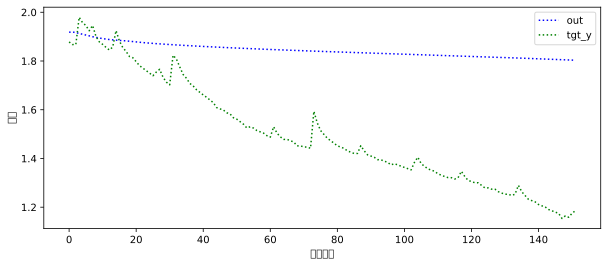

epoch:1199 , loss:0.0004733183 , MAE:0.3371 , RMSE:0.3825 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

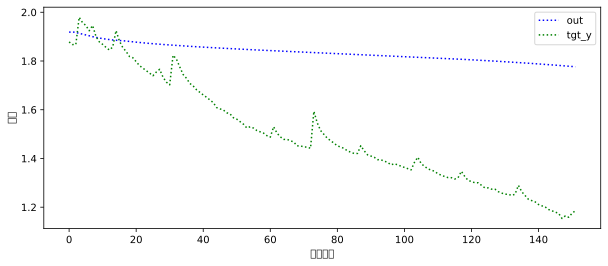

epoch:1299 , loss:0.0004295801 , MAE:0.3514 , RMSE:0.3991 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

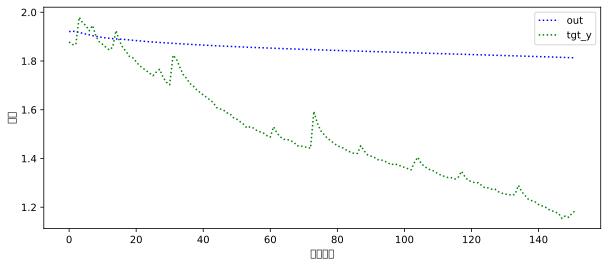

epoch:1399 , loss:0.0003923807 , MAE:0.3589 , RMSE:0.4075 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

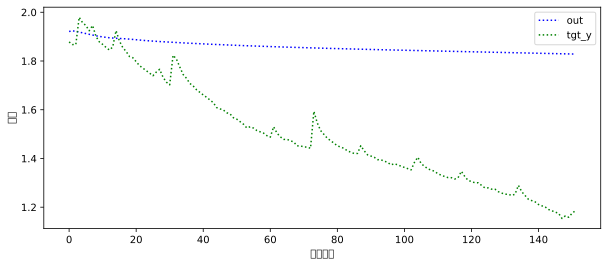

epoch:1499 , loss:0.0003149276 , MAE:0.3642 , RMSE:0.4134 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

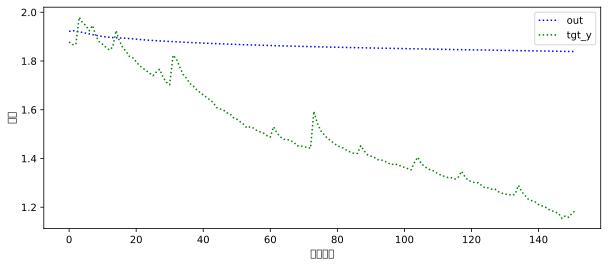

epoch:1599 , loss:0.0003438930 , MAE:0.3132 , RMSE:0.3503 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

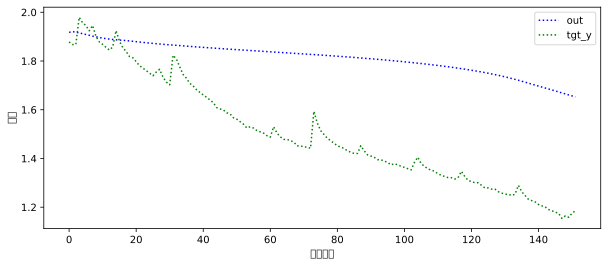

epoch:1699 , loss:0.0002994769 , MAE:0.3725 , RMSE:0.4220 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

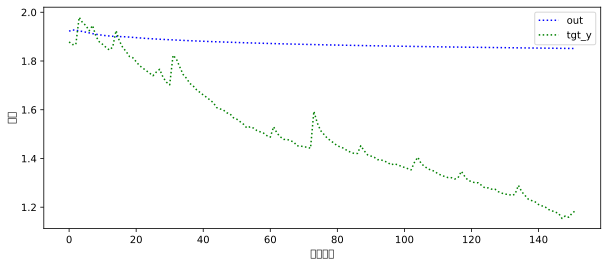

epoch:1799 , loss:0.0003253386 , MAE:0.2571 , RMSE:0.2812 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

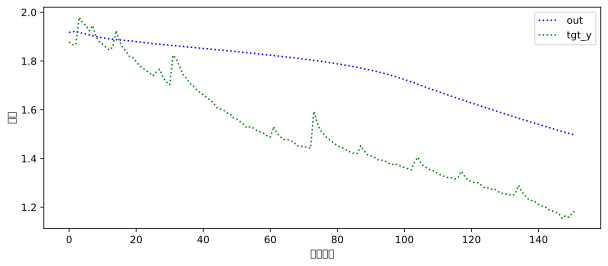

epoch:1899 , loss:0.0002997860 , MAE:0.3580 , RMSE:0.4039 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

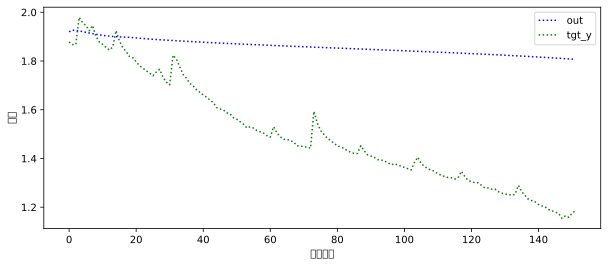

epoch:1999 , loss:0.0003521047 , MAE:0.2810 , RMSE:0.3084 , RE:0.6344


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

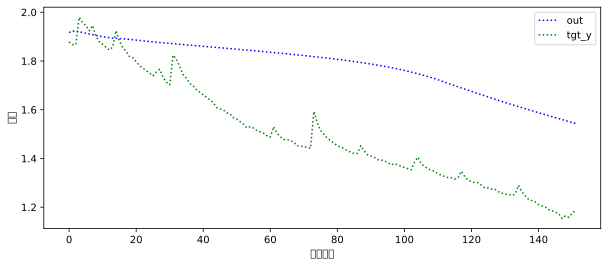

以电池 B0007 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0082361717 , MAE:0.1392 , RMSE:0.1638 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

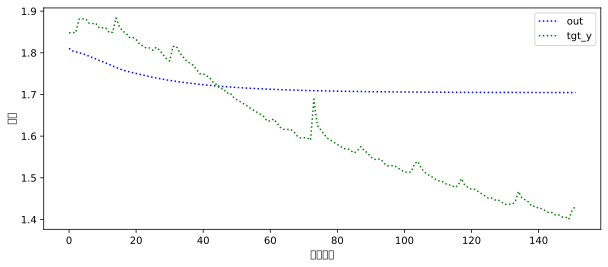

epoch:199  , loss:0.0046576648 , MAE:0.1859 , RMSE:0.2243 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

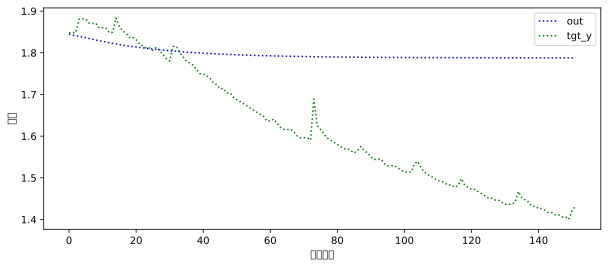

epoch:299  , loss:0.0025825431 , MAE:0.2471 , RMSE:0.2880 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

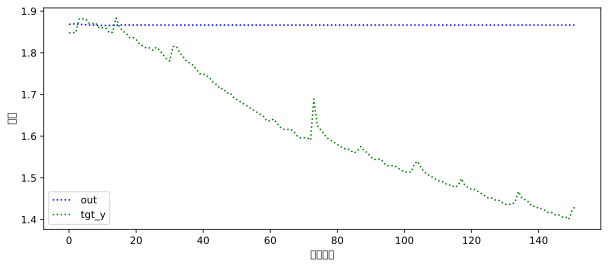

epoch:399  , loss:0.0017669840 , MAE:0.2726 , RMSE:0.3134 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

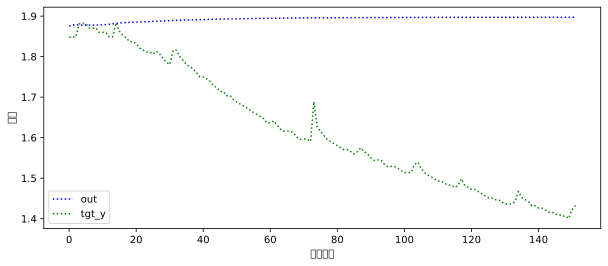

epoch:499  , loss:0.0014176146 , MAE:0.2664 , RMSE:0.3076 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

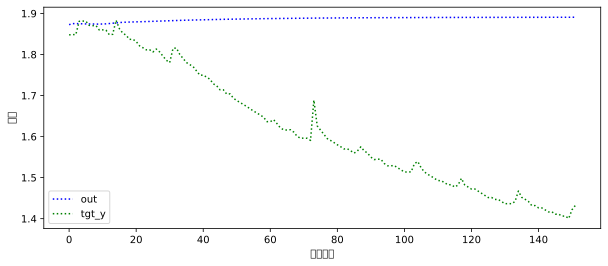

epoch:599  , loss:0.0012990113 , MAE:0.2531 , RMSE:0.2944 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

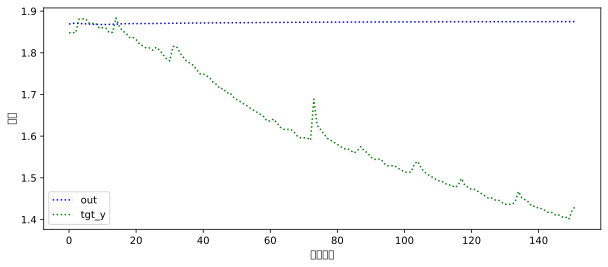

epoch:699  , loss:0.0008842853 , MAE:0.2672 , RMSE:0.3087 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

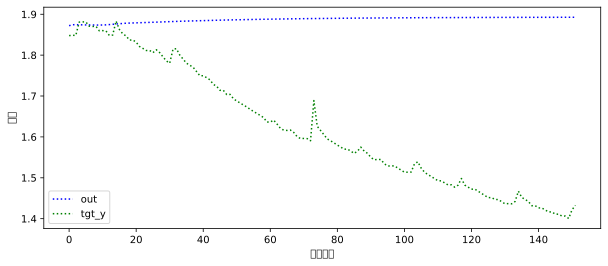

epoch:799  , loss:0.0009255324 , MAE:0.2739 , RMSE:0.3157 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

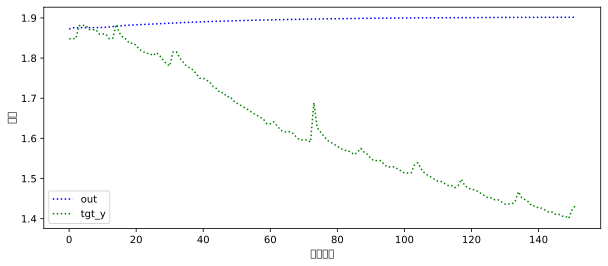

epoch:899  , loss:0.0010281148 , MAE:0.2579 , RMSE:0.2996 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

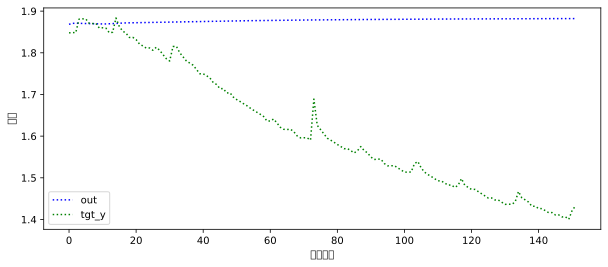

epoch:999  , loss:0.0008838773 , MAE:0.2325 , RMSE:0.2718 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

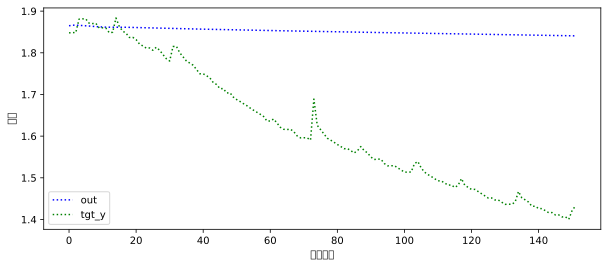

epoch:1099 , loss:0.0008788090 , MAE:0.2703 , RMSE:0.3135 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

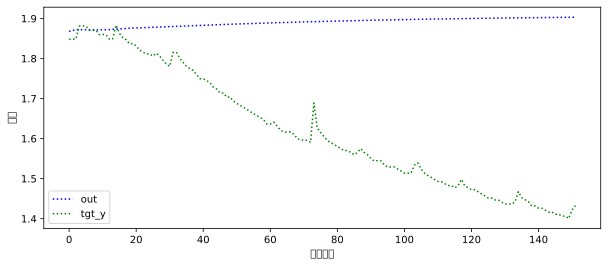

epoch:1199 , loss:0.0004138123 , MAE:0.1930 , RMSE:0.2242 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

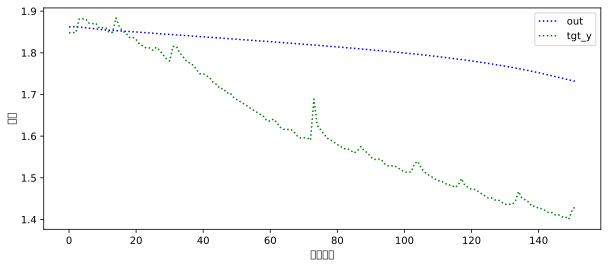

epoch:1299 , loss:0.0003534703 , MAE:0.2045 , RMSE:0.2382 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

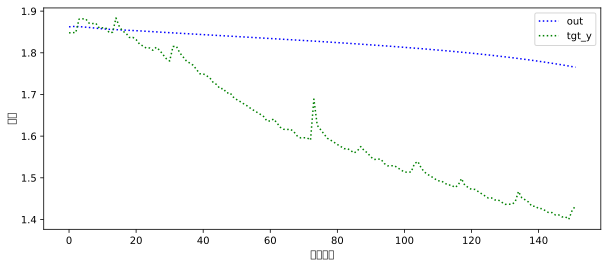

epoch:1399 , loss:0.0003331121 , MAE:0.1833 , RMSE:0.2116 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

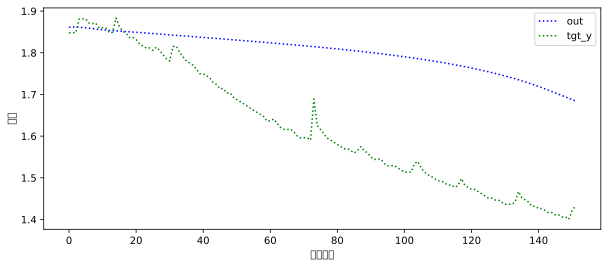

epoch:1499 , loss:0.0004784990 , MAE:0.1408 , RMSE:0.1602 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

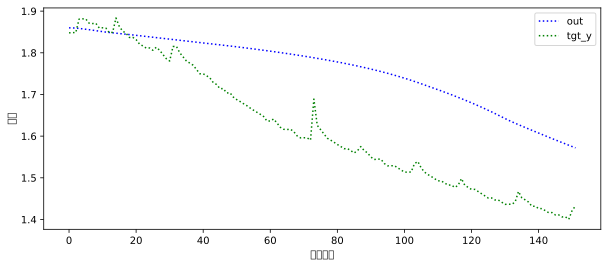

epoch:1599 , loss:0.0003548093 , MAE:0.0862 , RMSE:0.0981 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

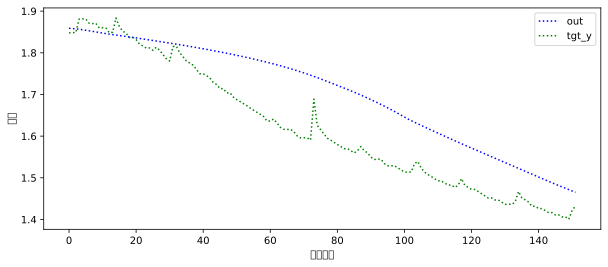

epoch:1699 , loss:0.0004839413 , MAE:0.0700 , RMSE:0.0806 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

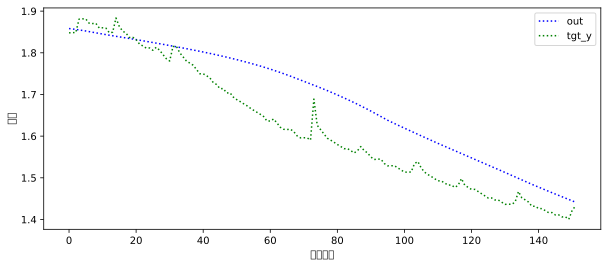

epoch:1799 , loss:0.0003665360 , MAE:0.0613 , RMSE:0.0723 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

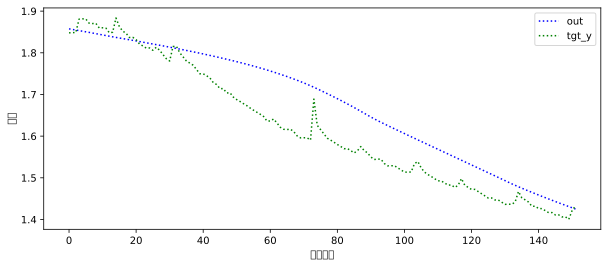

epoch:1899 , loss:0.0002942165 , MAE:0.0719 , RMSE:0.0827 , RE:0.2763


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

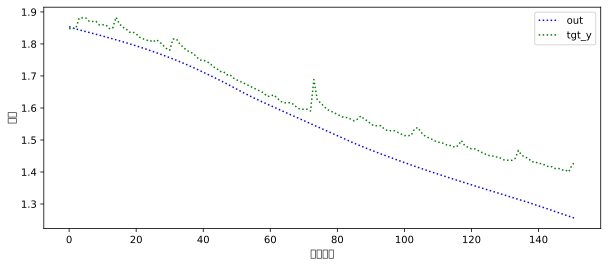

epoch:1999 , loss:0.0004434151 , MAE:0.1444 , RMSE:0.1640 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

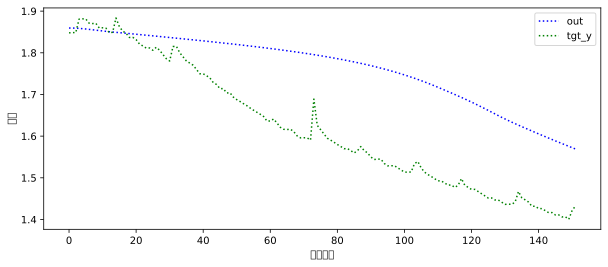

以电池 B0018 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0100967176 , MAE:0.1066 , RMSE:0.1300 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

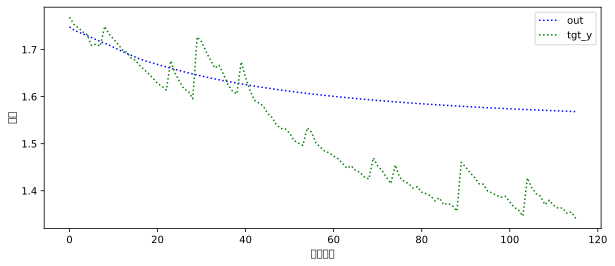

epoch:199  , loss:0.0048082480 , MAE:0.2065 , RMSE:0.2297 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

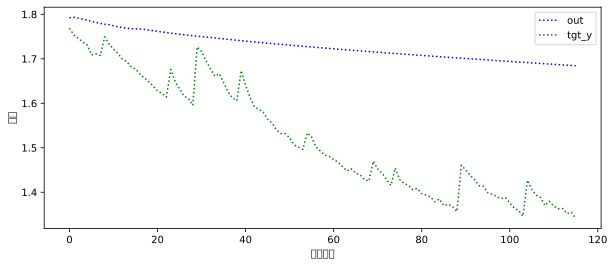

epoch:299  , loss:0.0024393536 , MAE:0.2552 , RMSE:0.2811 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

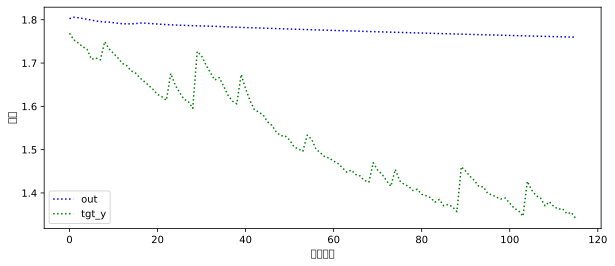

epoch:399  , loss:0.0013593904 , MAE:0.2543 , RMSE:0.2799 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

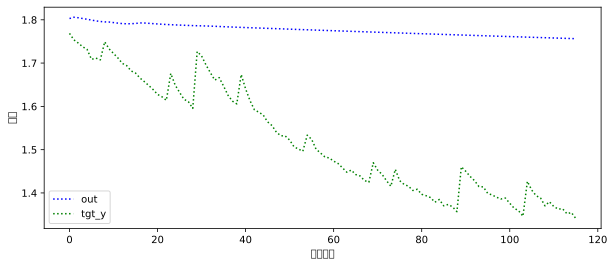

epoch:499  , loss:0.0012414432 , MAE:0.1906 , RMSE:0.2072 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

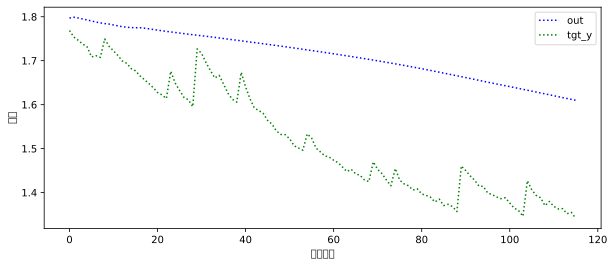

epoch:599  , loss:0.0012095139 , MAE:0.1700 , RMSE:0.1855 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

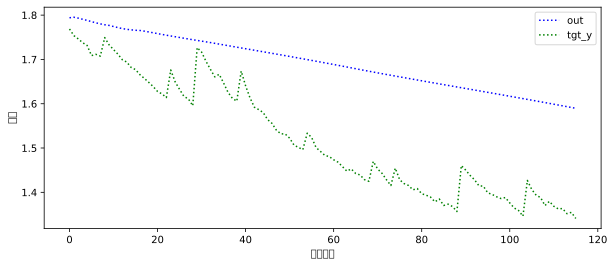

epoch:699  , loss:0.0009475902 , MAE:0.2158 , RMSE:0.2357 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

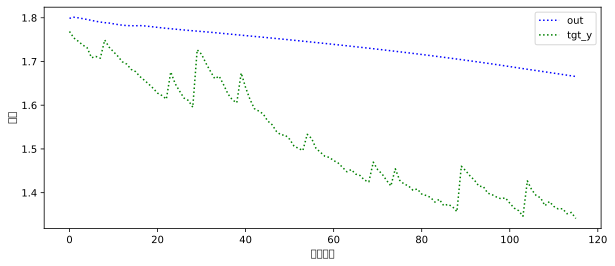

epoch:799  , loss:0.0006474275 , MAE:0.1668 , RMSE:0.1805 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

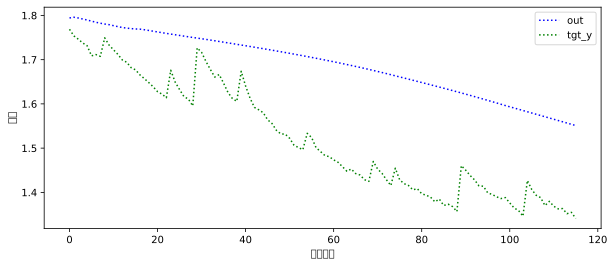

epoch:899  , loss:0.0006870652 , MAE:0.1487 , RMSE:0.1600 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

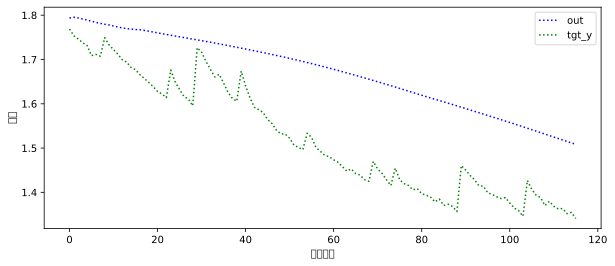

epoch:999  , loss:0.0008292674 , MAE:0.2394 , RMSE:0.2622 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

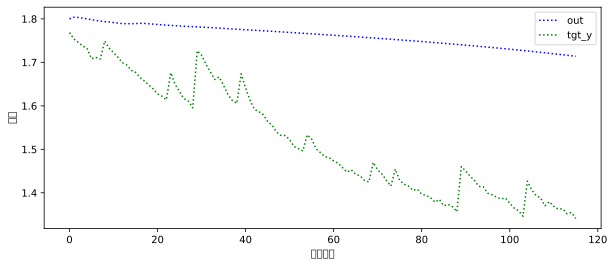

epoch:1099 , loss:0.0005634147 , MAE:0.1276 , RMSE:0.1363 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

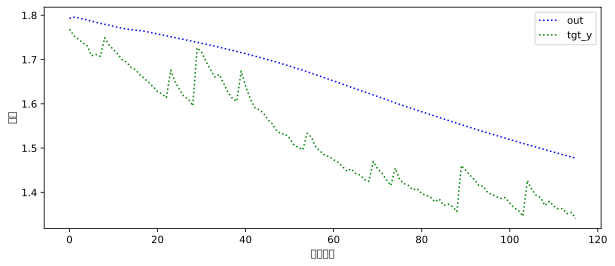

epoch:1199 , loss:0.0006782672 , MAE:0.0533 , RMSE:0.0605 , RE:0.3333


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

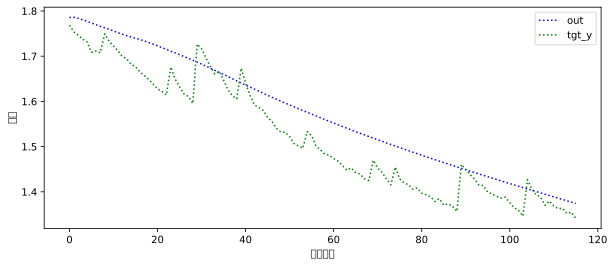

epoch:1299 , loss:0.0005625917 , MAE:0.0916 , RMSE:0.0983 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

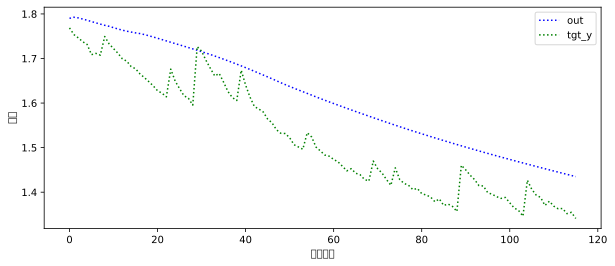

epoch:1399 , loss:0.0005318208 , MAE:0.0575 , RMSE:0.0643 , RE:0.3827


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

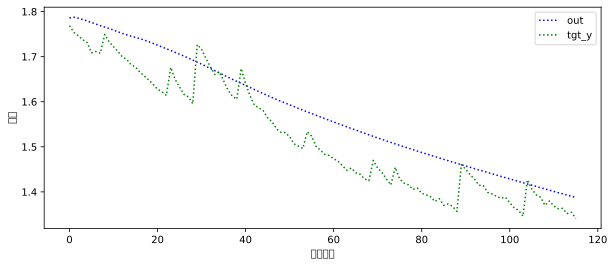

epoch:1499 , loss:0.0006512186 , MAE:0.0654 , RMSE:0.0717 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

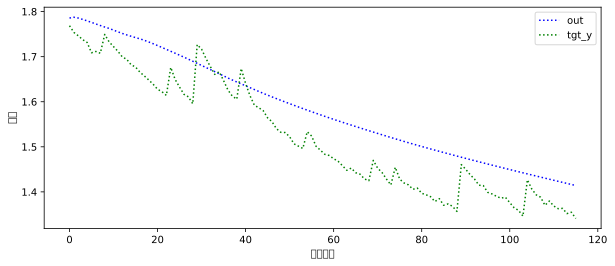

epoch:1599 , loss:0.0003371508 , MAE:0.0579 , RMSE:0.0644 , RE:0.4198


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

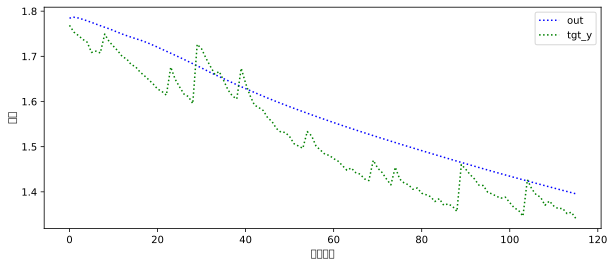

epoch:1699 , loss:0.0002026709 , MAE:0.0382 , RMSE:0.0443 , RE:0.2716


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

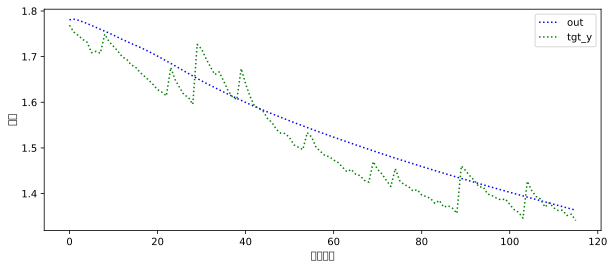

epoch:1799 , loss:0.0003627988 , MAE:0.0885 , RMSE:0.0950 , RE:0.4321


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

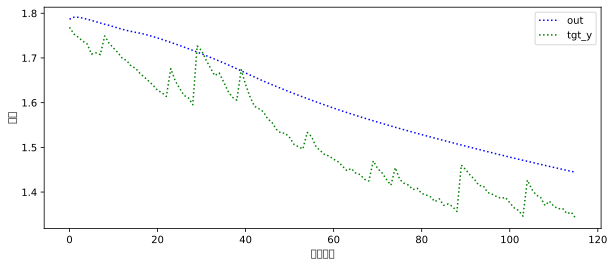

epoch:1899 , loss:0.0004367076 , MAE:0.0343 , RMSE:0.0403 , RE:0.2346


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

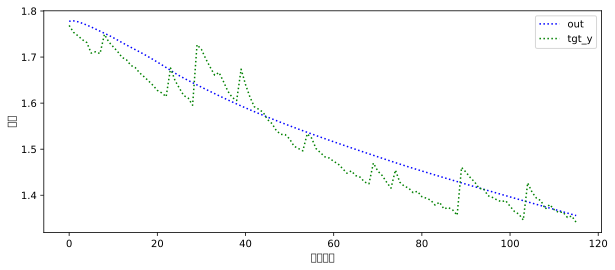

epoch:1999 , loss:0.0003016991 , MAE:0.0495 , RMSE:0.0558 , RE:0.3457


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

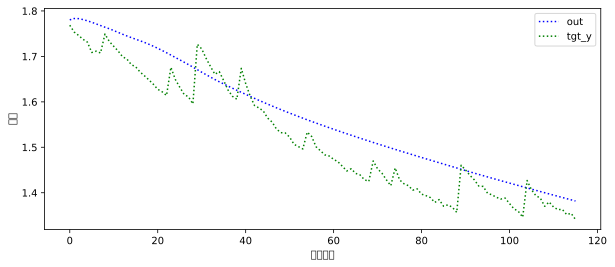

---------------------------------
re_s [0.1926605504587156, 0.6344086021505376, 0.0, 0.345679012345679]
---------------------------------
re mean: 0.29318704123873307
mae mean: 0.13205774989288363
rmse mean: 0.14729984149381734
---------------------------------


In [15]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.0001
weight_decay = 0.00001
num_epochs = 2000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
# for i in range(1):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)
    
    # 模型、损失函数、优化器
    net = Net(d_model=d_model, nhead=nhead,
              num_encoder_layers=num_encoder_layers, 
              dim_feedforward=dim_feedforward)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae, rmse, re = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')